<a href="https://colab.research.google.com/github/Zein-Zeus/drowsiness-and-yawn-detection/blob/main/Drowsiness-and-yawn-detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

-> Loading the predictor and detector...


<IPython.core.display.Javascript object>

call


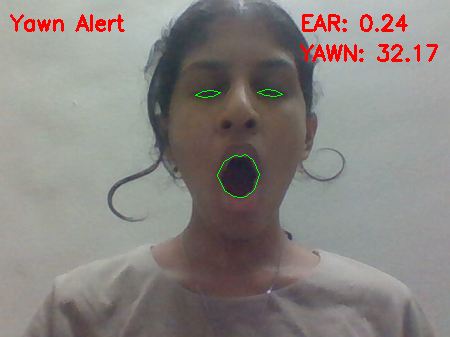

Error reading frame. Exiting...


In [60]:
#problem statement:The goal is to create a complete prototype that can be
#integrated into vehicles to enhance road safety.
from imutils.video import VideoStream
from imutils import face_utils
from threading import Thread
import numpy as np
import argparse
import imutils
import time
import dlib
import cv2
import os

# Define a function to trigger an alarm message
def alarm(msg):
    global alarm_status
    global alarm_status2
    global saying

    while alarm_status:
        print('call')
        s = 'espeak "'+msg+'"'
        os.system(s)

    if alarm_status2:
        print('call')
        saying = True
        s = 'espeak "' + msg + '"'
        os.system(s)
        saying = False

# Define a function to calculate the eye aspect ratio (EAR)
def eye_aspect_ratio(eye):
    A = dist.euclidean(eye[1], eye[5])
    B = dist.euclidean(eye[2], eye[4])

    C = dist.euclidean(eye[0], eye[3])

    ear = (A + B) / (2.0 * C)

    return ear

# Define a function to calculate the final EAR for both eyes
def final_ear(shape):
    (lStart, lEnd) = face_utils.FACIAL_LANDMARKS_IDXS["left_eye"]
    (rStart, rEnd) = face_utils.FACIAL_LANDMARKS_IDXS["right_eye"]

    leftEye = shape[lStart:lEnd]
    rightEye = shape[rStart:rEnd]

    leftEAR = eye_aspect_ratio(leftEye)
    rightEAR = eye_aspect_ratio(rightEye)

    ear = (leftEAR + rightEAR) / 2.0
    return (ear, leftEye, rightEye)

# Define a function to calculate lip distance for yawn detection
def lip_distance(shape):
    top_lip = shape[50:53]
    top_lip = np.concatenate((top_lip, shape[61:64]))

    low_lip = shape[56:59]
    low_lip = np.concatenate((low_lip, shape[65:68]))

    top_mean = np.mean(top_lip, axis=0)
    low_mean = np.mean(low_lip, axis=0)

    distance = abs(top_mean[1] - low_mean[1])
    return distance

# Parse command line arguments
ap = argparse.ArgumentParser()
ap.add_argument("-w", "--webcam", type=int, default=0,
                help="index of the webcam on the system")
args = vars(ap.parse_args())

# Define thresholds and counters
EYE_AR_THRESH = 0.3
EYE_AR_CONSEC_FRAMES = 30
YAWN_THRESH = 20
alarm_status = False
alarm_status2 = False
saying = False
COUNTER = 0

# Load face detection and shape prediction models
print("-> Loading the predictor and detector...")
detector = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")  # Use Colab's built-in Haar Cascade
predictor = dlib.shape_predictor('shape_predictor_68_face_landmarks.dat')

# Start the video stream using Colab's webcam capture
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
    js = Javascript('''
        async function takePhoto(quality) {
          const div = document.createElement('div');
          const capture = document.createElement('button');
          capture.textContent = 'Capture';
          div.appendChild(capture);

          const video = document.createElement('video');
          video.style.display = 'block';
          const stream = await navigator.mediaDevices.getUserMedia({ 'audio': false, 'video': true });
          document.body.appendChild(div);
          div.appendChild(video);
          video.srcObject = stream;
          await video.play();

          // Resize the output to fit the video element.
          google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

          // Wait for Capture to be clicked.
          const result = await new Promise(async (resolve) => {
            capture.onclick = () => {
              const canvas = document.createElement('canvas');
              canvas.width = video.videoWidth;
              canvas.height = video.videoHeight;
              canvas.getContext('2d').drawImage(video, 0, 0);
              stream.getVideoTracks()[0].stop();
              div.remove();
              resolve(canvas.toDataURL('image/jpeg', quality));
            }

            // Wait for 'q' key press to exit.
            document.addEventListener('keydown', (e) => {
              if (e.key === 'q') {
                stream.getVideoTracks()[0].stop();
                div.remove();
                resolve(null);
              }
            });
          });

          return result;
        }
    ''')
    display(js)
    data = eval_js('takePhoto({})'.format(quality))
    if data is not None:
        binary = b64decode(data.split(',')[1])
        with open(filename, 'wb') as f:
            f.write(binary)
    return data

# Take a photo using Colab's webcam capture
result = take_photo()

# Check if a photo was taken and the 'q' key was not pressed
if result is not None:
    vs = cv2.VideoCapture('photo.jpg')
    # Rest of your code...

while True:
    ret, frame = vs.read()

    # Check if the frame was successfully read
    if not ret:
        print("Error reading frame. Exiting...")
        break

    frame = imutils.resize(frame, width=450)
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)


    # Detect faces in the frame using Haar Cascade
    rects = detector.detectMultiScale(gray, scaleFactor=1.1,
                                      minNeighbors=5, minSize=(30, 30),
                                      flags=cv2.CASCADE_SCALE_IMAGE)

    for (x, y, w, h) in rects:
        rect = dlib.rectangle(int(x), int(y), int(x + w), int(y + h))

        shape = predictor(gray, rect)
        shape = face_utils.shape_to_np(shape)

        eye = final_ear(shape)
        ear = eye[0]
        leftEye = eye[1]
        rightEye = eye[2]

        distance = lip_distance(shape)

        leftEyeHull = cv2.convexHull(leftEye)
        rightEyeHull = cv2.convexHull(rightEye)
        cv2.drawContours(frame, [leftEyeHull], -1, (0, 255, 0), 1)
        cv2.drawContours(frame, [rightEyeHull], -1, (0, 255, 0), 1)

        lip = shape[48:60]
        cv2.drawContours(frame, [lip], -1, (0, 255, 0), 1)

        # Check for drowsiness
        if ear < EYE_AR_THRESH:
            COUNTER += 1

            if COUNTER >= EYE_AR_CONSEC_FRAMES:
                if alarm_status == False:
                    alarm_status = True
                    t = Thread(target=alarm, args=('Wake up, sir!',))
                    t.deamon = True
                    t.start()

                cv2.putText(frame, "DROWSINESS ALERT!", (10, 30),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
        else:
            COUNTER = 0
            alarm_status = False

        # Check for yawn
        if distance > YAWN_THRESH:
            cv2.putText(frame, "Yawn Alert", (10, 30),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
            if alarm_status2 == False and saying == False:
                alarm_status2 = True
                t = Thread(target=alarm, args=('Take some fresh air, sir!',))
                t.deamon = True
                t.start()
        else:
            alarm_status2 = False

        # Display EAR and YAWN values on the frame
        cv2.putText(frame, "EAR: {:.2f}".format(ear), (300, 30),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
        cv2.putText(frame, "YAWN: {:.2f}".format(distance), (300, 60),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)

    # Show the frame
    from google.colab.patches import cv2_imshow
    cv2_imshow(frame)

    if key == ord("q"):
        break

cv2.destroyAllWindows()
vs.release()
